# Initalize and install dependencies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image

from tqdm import tqdm
import shutil

from pathlib import Path

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bryanb/abstract-art-gallery")

data_root = ""
vangogh_path = "/content/starry/"
photo_path = path+"/Abstract_gallery/Abstract_gallery"

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
class vangoghPhoto(Dataset):
    def __init__(self, data_root, vangogh_path, photo_path, transform=None):
        self.data_root = data_root
        self.vangogh_path = vangogh_path
        self.vangogh_images = os.listdir(os.path.join(data_root, vangogh_path))
        self.photo_path = photo_path
        self.photo_images = os.listdir(os.path.join(data_root, photo_path))
        self.transform = transform
    def __len__(self):
        return max(len(self.vangogh_images), len(self.photo_images))

    def __getitem__(self, idx):
        try:
            vangogh_image = Image.open(os.path.join(data_root, vangogh_path, self.vangogh_images[idx % len(self.vangogh_images)]))
            photo_image = Image.open(os.path.join(data_root, photo_path, self.photo_images[idx % len(self.photo_images)]))
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            # Handle the error by skipping this sample, or logging it
            raise Exception(f"Error loading image at index {idx}: {e}");
        if self.transform:
            vangogh_image = self.transform(vangogh_image)
            photo_image = self.transform(photo_image)
        return vangogh_image, photo_image

In [33]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

dataset = vangoghPhoto(data_root, vangogh_path, photo_path, transform=transforms)

In [34]:
train_size, test_size = int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)

In [35]:
training_data, testing_data = random_split(dataset, [train_size, test_size])

In [36]:
train_dataloader = DataLoader(training_data.dataset, batch_size=32, shuffle=True, num_workers=12)
test_dataloader = DataLoader(testing_data.dataset, batch_size=32, shuffle=True, num_workers=12)

In [37]:
# Testing the train_dataloader
for i, (vangogh_images, photo_images) in enumerate(train_dataloader):
    print(f"Batch {i+1}")
    print(f"Van Gogh images shape: {vangogh_images.shape}")
    print(f"Photo images shape: {photo_images.shape}")
    break  # Stop after the first batch for testing

# Testing the test_dataloader
for i, (vangogh_images, photo_images) in enumerate(test_dataloader):
    print(f"Batch {i+1}")
    print(f"Van Gogh images shape: {vangogh_images.shape}")
    print(f"Photo images shape: {photo_images.shape}")
    break


Batch 1
Van Gogh images shape: torch.Size([32, 3, 256, 256])
Photo images shape: torch.Size([32, 3, 256, 256])
Batch 1
Van Gogh images shape: torch.Size([32, 3, 256, 256])
Photo images shape: torch.Size([32, 3, 256, 256])


In [38]:
mones, photos = next(iter(train_dataloader))
plt.imshow(mones[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)


KeyboardInterrupt



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, device="cuda"):
        super().__init__()
        self.device = device
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect', device=self.device),
            nn.BatchNorm2d(out_channels, device=self.device),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512], device="cuda"):
        super().__init__()
        self.device = device
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect', device=self.device),
            nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2, device=self.device),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect', device=self.device
            )
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return self.model(x)

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act = 'relu', use_dropout=False, device="cuda"):
        super().__init__()
        self.device = device
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect', device=self.device)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False, device=self.device),
            nn.BatchNorm2d(out_channels, device=self.device),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64, device="cuda"):
        super().__init__()
        self.device = device
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect', device=self.device),
            nn.LeakyReLU(0.2),
        ) #128

        self.down1 = Block(features, features*2, down=True, act='leaky', use_dropout=False)   #64
        self.down2 = Block(features*2, features*4, down=True, act='leaky', use_dropout=False) #32
        self.down3 = Block(features*4, features*8, down=True, act='leaky', use_dropout=False) #16
        self.down4 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #8
        self.down5 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #4
        self.down6 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode='reflect', device=self.device), #1x1
            nn.ReLU(),
        )
        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=False)
        self.finil_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1, device=self.device),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)

        bottleneck = self.bottleneck(d7)

        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))

        return self.finil_up(torch.cat([up7, d1], 1))

In [ ]:
class Trainer:
    def __init__(
        self,
        train_data: DataLoader,
        val_data: DataLoader,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        nb_epochs: int = 5,
        device: str = "cuda",
        save_path: str = None,
    ):
        self.train_data = train_data
        self.val_data = val_data
        self.generator = generator
        self.discriminator = discriminator
        self.nb_epochs = nb_epochs
        self.device = device
        self.save_path = Path(save_path) if save_path else save_path

        self.z = next(iter(self.val_data))[0][:32].to(self.device)

        self.logs = {
            "Step": [],
            "Train_g_loss": [],
            "Train_d_loss": [],
            "Val_g_loss": [],
            "Val_d_loss": [],
            "Samples": [],
        }

    def init_optimizers(self, lr: float=3e-4, betas: tuple=(0.5, 0.999)):
        self.g_optimizer = torch.optim.Adam(
            self.generator.parameters(), lr=lr, betas=betas
        )
        self.d_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), lr=lr, betas=betas
        )

    def train(self):
        assert (self.g_optimizer is not None) and (
            self.d_optimizer is not None
        ), "Please run Trainer().init_optimizer()"

        # Loading best model
        if self.save_path and self.save_path.exists():
            self.load_model()

        best_score = torch.inf

        for i in range(self.nb_epochs):
            train_d_loss, train_g_loss, val_d_loss, val_g_loss = 0, 0, 0, 0
            self.generator.train()
            self.discriminator.train()
            # Train loop
            loop = tqdm(
                enumerate(self.train_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} train",
                leave=False,
                total=len(self.train_data),
            )
            for step, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                # Train step
                g_loss, d_loss = self.train_step(x, y)

                train_g_loss += g_loss
                train_d_loss += d_loss

                loop.set_postfix_str(
                    f"g_loss: {train_g_loss / (step + 1) :.2f}, d_loss: {train_d_loss / (step + 1) :.2f}"
                )

            # Validation loop
            self.generator.eval()
            self.discriminator.eval()

            loop = tqdm(
                enumerate(self.val_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} validation",
                leave=True,
                total=len(self.val_data),
            )
            for step, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                # Validation step
                g_loss, d_loss = self.val_step(x, y)

                val_g_loss += g_loss
                val_d_loss += d_loss

                loop.set_postfix_str(
                    f"g_loss: {val_g_loss / (step + 1) :.2f} d_loss: {val_d_loss / (step + 1) :.2f}"
                )

            # Saving best model
            if self.save_path and best_score > val_g_loss:
                best_score = val_g_loss
                self.save_model()

            # Log
            self.log_metrics(
                step=i,
                train_g_loss=train_g_loss,
                train_d_loss=train_d_loss,
                val_g_loss=val_g_loss,
                val_d_loss=val_d_loss,
            )
            # plot
            fake_img = self.generator((photos[0].unsqueeze(0)).to('cuda'))
            fake_img = fake_img[0].cpu().detach()

            fig, ax = plt.subplots(1, 2, figsize=(20, 4))
            ax[0].imshow(photos[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
            ax[0].set_title("Photo")
            ax[0].set(xticks=[], yticks=[])
            ax[1].imshow(fake_img.permute(1, 2, 0).numpy() * 0.5 + 0.5  )
            ax[1].set_title("Fakevangogh")
            ax[1].set(xticks=[], yticks=[])
            plt.show()

        return self.logs

    def train_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor
    ) -> tuple:
        self.g_optimizer.zero_grad(set_to_none=True)
        self.d_optimizer.zero_grad(set_to_none=True)

        fake_ = self.discriminator(
            self.generator(x)
        )
        real = self.discriminator(y)
        d_loss = (
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=self.device)) +
            torch.nn.functional.mse_loss(fake_, torch.zeros_like(fake_, device=self.device))
        )

        d_loss.backward()
        self.d_optimizer.step()

        fake = self.discriminator(
            self.generator(x)
        )

        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=self.device))
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def val_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> tuple:
        fake = self.discriminator(
            self.generator(x)
        )
        real = self.discriminator(y)
        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=self.device))
        d_loss = (
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=self.device)) +
            torch.nn.functional.mse_loss(fake, torch.zeros_like(fake, device=self.device))
        )
        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def log_metrics(
        self,
        step: int,
        train_g_loss: torch.Tensor,
        train_d_loss: torch.Tensor,
        val_g_loss: torch.Tensor,
        val_d_loss: torch.Tensor,
    ):
        self.logs["Step"].append(step)
        self.logs["Train_g_loss"].append(train_g_loss / len(self.train_data))
        self.logs["Train_d_loss"].append(train_d_loss / len(self.train_data))
        self.logs["Val_g_loss"].append(val_g_loss / len(self.val_data))
        self.logs["Val_d_loss"].append(val_d_loss / len(self.val_data))
        self.logs["Samples"].append(make_grid(self.generator(self.z).cpu() * 0.5 + 0.5, normalize=True))

    def save_model(self, full: bool = False):
        if full:
            torch.save(self.generator, Path(self.save_path) / "generator.pth")
            torch.save(self.discriminator, Path(self.save_path) / "discriminator.pth")
        else:
            torch.save(
                self.generator.state_dict(),
                Path(self.save_path) / "generator_weights.pth",
            )
            torch.save(
                self.discriminator.state_dict(),
                Path(self.save_path) / "discriminator_weights.pth",
            )

    save_dir = "models/"

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def load_model(self, full: bool = False):
        if (
            full
            and (self.save_path / "generator.pth").is_file()
            and (self.save_path / "discriminator.pth").is_file()
        ):
            self.generator = torch.load(self.save_path / "generator.pth")
            self.discriminator = torch.load(self.save_path / "discriminator.pth")
        elif (
            self.save_path / "generator_weights.pth"
        ).is_file() and (
            self.save_path / "discriminator_weights.pth"
        ).is_file():
            self.generator.load_state_dict(torch.load(self.save_path / "generator_weights.pth"))
            self.discriminator.load_state_dict(torch.load(self.save_path / "discriminator_weights.pth"))

trainer = Trainer(
        train_data = train_dataloader,
        val_data = test_dataloader,
        generator = Generator(in_channels=3, features=64),
        discriminator = Discriminator(),
        nb_epochs = 30,
        device = device,
        save_path = 'models/'
    )


trainer.init_optimizers()
logs = trainer.train()


trainer.load_model()
trainer.init_optimizers()
logs = trainer.train()



# Testing the model

In [ ]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Load the trained generator
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = Generator(in_channels=3, features=64)  # Define your generator architecture
generator.load_state_dict(torch.load("models/generator_weights.pth", map_location=device))
generator.to(device).eval()  # Switch to evaluation mode


C:\Users\Tony Zhang\AppData\Local\Temp\ipykernel_19800\67141212.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("models/generator_we

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [ ]:
from PIL import Image

# Define the same transformations used during training
transform = Compose([
    Resize((256, 256)),          # Resize to the input size expected by the model
    ToTensor(),                  # Convert the image to a PyTorch tensor
    Normalize(mean=0.5, std=0.5) # Normalize to the range [-1, 1] (same as training)
])

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB format
    return transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

photo_path = "D:\\Uni\\CS-4640-final\\outputs\\0b6b4bfc29.jpg" #path to image to convert
photo_tensor = preprocess_image(photo_path)

In [ ]:
# Generate the "Fake vangogh" image
with torch.no_grad():  # Disable gradient calculations for inference
    fake_vangogh = generator(photo_tensor)

# Denormalize the image back to [0, 1] range
fake_vangogh = fake_vangogh.squeeze(0).cpu() * 0.5 + 0.5

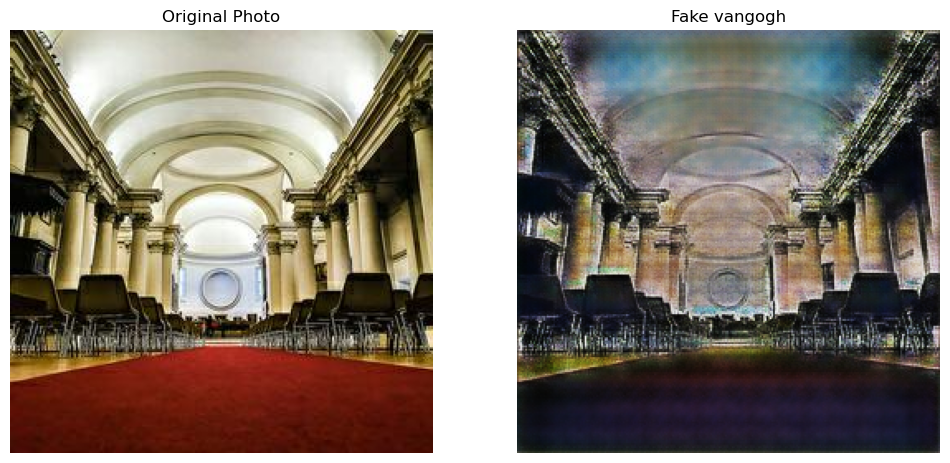

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Load the original photo for display
original_photo = Image.open(photo_path)

# Convert the tensor to a PIL image for the generated "Fake vangogh"
fake_vangogh_image = F.to_pil_image(fake_vangogh)

# Plot both images side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original Photo
ax[0].imshow(original_photo)
ax[0].axis("off")
ax[0].set_title("Original Photo")

# Fake vangogh
ax[1].imshow(fake_vangogh_image)
ax[1].axis("off")
ax[1].set_title("Fake vangogh")

plt.show()
